Student's Name and Email Address

Boise State University, Department of Chemistry and Biochemistry

## CHEM 324: PChem Lab {-}
# Worksheet 5: Differential Scanning Calorimetry (DSC) {-}

In [9]:
# @title Notebook Setup { display-mode: "form" }
# Import the main modules used in this worksheet
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.integrate import simpson, cumulative_trapezoid


In [10]:
# @title Functions to load the data { display-mode: "form" }
def load_data_to_file_dict(file_dict):
    """
    Load a DSC .txt file. 
    The format of the file should have two rows of headers, one extra line of text at the end, and five columns of data
    The columns are: index, time, heat flow, temperature of sample, temperature of reference

    Input variables:
        file_dict : a dictionary with 'path' and 'name' keys corresponding to the file to be loaded
    
    Action: 
        Add to file_dict a Pandas DataFrame with four columns: time (in seconds), heat flow (in W/g), 
        temperature of sample (in C), and temperature of reference (in C)
    """
    data = pd.read_csv(file_dict['path']+file_dict['name'],skiprows=2,skipfooter=1,names=['Time','Heat-Flow','Ts','Tr'],sep=' +',index_col=0,engine='python',encoding='unicode_escape') 
    file_dict['data'] = data
    return

def filter_data(peak_dict,verbose=False):
    """
    Given a file dictionary that contains two values for the time interval to analyze
    create a 'filtered_data' component with only the data in the specified time range

    By default, time_end = 0 corresponds to the end of the file

    Action:
        If not present, load the data from the file into peak_dict['data']
        Add peak_dict['filtered_data'] with only the part of the experiment within time_start and time_end
    """
    if not ('data' in peak_dict): 
        load_data_to_file_dict(peak_dict)
    time_start = peak_dict['time_start']
    time_end = peak_dict['time_end']
    if time_end == 0 : time_end = peak_dict['data'].Time.iat[-1]
    # 
    peak_dict['filtered_data'] = peak_dict['data'].query(f'Time > {time_start} and Time < {time_end}').copy()

def plot_peak(peak_dict,xaxis='Time'):
    """ 
    """
    if not ('data' in peak_dict): 
        load_data_to_file_dict(peak_dict)
    time_start = peak_dict['time_start']
    time_end = peak_dict['time_end']
    if time_end == 0 : time_end = peak_dict['data'].Time.iat[-1]
    # 
    filtered_data = peak_dict['data'].query(f'Time > {time_start} and Time < {time_end}')
    #
    if xaxis not in peak_dict['data']:
        print("ERROR: Invalid value for xaxis argument")
        return
    elif xaxis == 'Time' :
        plt.xlabel('Time [s]')
    elif xaxis == 'Ts' :
        plt.xlabel('Ts [C]')
    elif xaxis == 'Tr' :
        plt.xlabel('Tr [C]')
    plt.plot(filtered_data[xaxis],filtered_data['Heat-Flow'])
    plt.ylabel('Heat Flow [W/g]')
    plt.show()

def plot_peak_list(peak_list,xaxis='Time',key='',value=['']):
    """
    Given a list of dictionary files, plot temperature vs. time for each file into the same plot.
    If key/value are specified, only plot the files for which the key has the specified value.

    Input variables:
        file_list : a list of dictionary files, each with 'path' and 'name' keys corresponding to the file to be loaded
        key: a string with the name of the key to shortlist the files
        value: the value of the key used to select the shortlist of files
    
    Action: 
        Plot temperature vs. time for the selected files  
    """
    if value == '' or key == '':
        peak_shortlist = peak_list
    else :
        peak_shortlist = [f for f in peak_list if f[key] in value ]
    #
    fig, ax = plt.subplots()
    if xaxis == 'Time' :
        plt.xlabel('Time [s]')
    elif xaxis == 'Ts' :
        plt.xlabel('Ts [C]')
    elif xaxis == 'Tr' :
        plt.xlabel('Tr [C]')
    else:
        print("ERROR: unexpected xaxis label")
        return
    #
    for peak in peak_shortlist : 
        filter_data(peak)
        plt.plot(peak['filtered_data'][xaxis],peak['filtered_data']['Heat-Flow'],label=peak['label'])
    plt.ylabel('Heat-Flow [W/g]')
    plt.legend()
    plt.show()

def line_of_tuple(x,params):
    """ 
    given a list of 3 parameters compute a line according to 
        y(x) = params[2] + params[0]*(x-params[1])
    """
    return params[0]*(x-params[1]) + params[2]

def intersection_of_lines(params1,params2):
    """ 
    Given the equations of two lines (y(x) = params[2] + params[0]*(x-params[1])) 
    find the intersection point: 
        y01 + slope1*(x01 - x) = y02 + slope2*(x02 - x) 
        (slope2 - slope1) * x = (y02 - y01) + (slope2*x02-slope1*x01)
        x = ((y02 - y01) + (slope2*x02-slope1*x01)) / (slope2 - slope1) 
    """
    if params1[0] == params2[0] :
        raise ValueError("ERROR: the two lines are parallel, no (unique) intersection")
    x = (params2[2] - params1[2] - params2[0]*params2[1] + params1[0]*params1[1])/(params1[0]-params2[0])
    y = line_of_tuple(x,params1)
    return x,y

def calc_baseline(peak_dict,xaxis='Time',verbose=False):
    """ 
    Compute a baseline for the data according to a few alternative options

    Baseline types, specified in the peak_dict['baseline_type'] component, can be:
        line-right = a line tangent to the right extreme of the data
        line-left = a line tangent to the left extreme of the data
        line-horizontal-right = a flat line passing throught the right extreme
        line-horizontal-left = a flat line passing throught the left extreme
        integral = a smooth combination of left and right tangents 
        integral-horizontal = a smooth combination of left and right flat lines

    Action: 
        Compute left, right, and full baseline
        Add them to the peak_dict['filtered_data'] component
        Compute peak_dict['Heat-Flow-Clean'], the heat-flow minus the full baseline 
    """
    filter_data(peak_dict)
    filtered_data = peak_dict['filtered_data']
    filtered_data['dHF_dx'] = np.gradient(filtered_data['Heat-Flow'], filtered_data[xaxis])
    # 
    if 'line' in peak_dict['baseline_type'] : 
        xi = filtered_data[xaxis].iloc[0]
        yi = filtered_data['Heat-Flow'].iloc[0]
        xf = filtered_data[xaxis].iloc[-1]
        yf = filtered_data['Heat-Flow'].iloc[-1]
        if 'horizontal' in peak_dict['baseline_type'] :
            slope = 0.
        else :
            slope = (yf-yi)/(xf-xi)
        if 'right' in peak_dict['baseline_type'] :
            peak_dict['baseline-left'] = (slope,xf,yf)
            peak_dict['baseline-right'] = (slope,xf,yf)
            filtered_data['baseline'] = line_of_tuple(filtered_data[xaxis],peak_dict['baseline-right'])
        else :
            peak_dict['baseline-left'] = (slope,xi,yi)
            peak_dict['baseline-right'] = (slope,xi,yi)
            filtered_data['baseline'] = line_of_tuple(filtered_data[xaxis],peak_dict['baseline-left'])
    elif 'integral' in peak_dict['baseline_type'] : 
        xi = filtered_data[xaxis].iloc[0]
        yi = filtered_data['Heat-Flow'].iloc[0]
        if 'horizontal' in peak_dict['baseline_type'] :
            dydxi = 0
        else :
            dydxi = filtered_data['dHF_dx'].iloc[0]
        peak_dict['baseline-left'] = (dydxi,xi,yi)
        #
        xf = filtered_data[xaxis].iloc[-1]
        yf = filtered_data['Heat-Flow'].iloc[-1]
        if 'horizontal' in peak_dict['baseline_type'] :
            dydxf = 0
        else :
            dydxf = filtered_data['dHF_dx'].iloc[-1]
        peak_dict['baseline-right'] = (dydxf,xf,yf)
        filtered_data['baseline-right'] = line_of_tuple(filtered_data[xaxis],peak_dict['baseline-right'])
        filtered_data['baseline-left'] = line_of_tuple(filtered_data[xaxis],peak_dict['baseline-left'])
        baseline = np.ones(filtered_data['Heat-Flow'].shape)*(yi+yf)*0.5
        for i in range(10): 
            gamma = cumulative_trapezoid(filtered_data['Heat-Flow']-baseline,filtered_data[xaxis],initial=0)/simpson(filtered_data['Heat-Flow']-baseline,filtered_data[xaxis])
            baseline = (1-gamma)*filtered_data['baseline-left'] + gamma*filtered_data['baseline-right']
        filtered_data['baseline'] = baseline
    filtered_data['Heat-Flow-Clean'] = filtered_data['Heat-Flow'] - filtered_data['baseline']
    
def analyze_peak(peak_dict,verbose=False,xaxis='Time'):
    """ 
    """
    calc_baseline(peak_dict,xaxis)
    #
    filtered_data = peak_dict['filtered_data']
    # Compute the integral
    peak_integral = simpson(filtered_data['Heat-Flow-Clean'],filtered_data['Time'])
    peak_dict['integral'] = peak_integral
    peak_integral_xaxis = simpson(filtered_data['Heat-Flow-Clean'],filtered_data[xaxis])
    if verbose : print(f'The peak integral is {peak_integral:8.6f} J/g')
    # Peak position
    if peak_integral < 0 : 
        index_peak = np.argmin(filtered_data['Heat-Flow'])
    else : 
        index_peak = np.argmax(filtered_data['Heat-Flow'])
    x_peak = filtered_data[xaxis].iloc[index_peak]
    y_peak = filtered_data['Heat-Flow'].iloc[index_peak]
    peak_dict['peak'] = (x_peak,y_peak)
    # Inflaction points (max and min of first derivative are zeros of second derivative)
    left_data = filtered_data.iloc[:index_peak]
    if peak_integral_xaxis < 0 :
        index_inflection_left = np.argmin(left_data['dHF_dx'])
    else : 
        index_inflection_left = np.argmax(left_data['dHF_dx'])
    x_infl_left = left_data[xaxis].iloc[index_inflection_left]
    y_infl_left = left_data['Heat-Flow'].iloc[index_inflection_left]
    slope_infl_left = left_data['dHF_dx'].iloc[index_inflection_left]
    peak_dict['inflection1'] = (slope_infl_left, x_infl_left, y_infl_left)
    right_data = filtered_data.iloc[index_peak+1:]
    if peak_integral_xaxis < 0 :
        index_inflection_right = np.argmax(right_data['dHF_dx'])
    else : 
        index_inflection_right = np.argmin(right_data['dHF_dx'])
    x_infl_right = right_data[xaxis].iloc[index_inflection_right]
    y_infl_right = right_data['Heat-Flow'].iloc[index_inflection_right]
    slope_infl_right = right_data['dHF_dx'].iloc[index_inflection_right]
    peak_dict['inflection2'] = (slope_infl_right, x_infl_right, y_infl_right)
    # Onset
    onset_x, onset_y = intersection_of_lines(peak_dict['inflection1'],peak_dict['baseline-left'])
    peak_dict['onset'] = (onset_x,onset_y)
    # Endset
    endset_x, endset_y = intersection_of_lines(peak_dict['inflection2'],peak_dict['baseline-right'])
    peak_dict['endset'] = (endset_x,endset_y)
    # Extrapolated Peak
    extrapolated_peak_x, extrapolated_peak_y = intersection_of_lines(peak_dict['inflection1'],peak_dict['inflection2'])
    peak_dict['extrapolated_peak'] = (extrapolated_peak_x,extrapolated_peak_y)
    if verbose :
        plot_analysis(peak_dict,xaxis)

def plot_analysis(peak_dict,xaxis='Time'):
    """ 
    """
    if xaxis == 'Time' :
        units = ' s'
        xlabel = 'Time [s]'
    elif xaxis == 'Ts' :
        units = u'\N{DEGREE SIGN} C'
        xlabel = 'Ts [C]'
    elif xaxis == 'Tr' :
        units = u'\N{DEGREE SIGN} C'
        xlabel = 'Tr [C]'
    else:
        print("ERROR: unexpected xaxis label")
        return
    filtered_data = peak_dict['filtered_data']
    plt.plot(filtered_data[xaxis],filtered_data['Heat-Flow'])
    plt.plot(filtered_data[xaxis],line_of_tuple(filtered_data[xaxis],peak_dict['baseline-left']))
    plt.plot(filtered_data[xaxis],line_of_tuple(filtered_data[xaxis],peak_dict['baseline-right']))
    plt.plot(filtered_data[xaxis],filtered_data['baseline'])
    plt.scatter(peak_dict['extrapolated_peak'][0],peak_dict['extrapolated_peak'][1],label=f"Extrapolated Peak = {peak_dict['extrapolated_peak'][0]:6.2f}"+units)
    plt.scatter(peak_dict['onset'][0],peak_dict['onset'][1],label=f"Onset = {peak_dict['onset'][0]:6.2f}"+units)
    plt.scatter(peak_dict['endset'][0],peak_dict['endset'][1],label=f"Endset = {peak_dict['endset'][0]:6.2f}"+units)
    inflaction_points = [[peak_dict['inflection1'][1],peak_dict['inflection2'][1]],[peak_dict['inflection1'][2],peak_dict['inflection2'][2]]]
    plt.scatter(inflaction_points[0],inflaction_points[1],marker='x',label='Inflections')
    x_tmp = np.linspace(peak_dict['onset'][0],peak_dict['extrapolated_peak'][0],10)
    plt.plot(x_tmp,line_of_tuple(x_tmp,peak_dict['inflection1']),':',color='grey')
    x_tmp = np.linspace(peak_dict['extrapolated_peak'][0],peak_dict['endset'][0],10)
    plt.plot(x_tmp,line_of_tuple(x_tmp,peak_dict['inflection2']),':',color='grey')
    plt.legend()
    plt.ylabel('Heat Flow [W/g]')    
    plt.xlabel(xlabel)

def plot_analysis_list(peak_list,xaxis='Time'):
    """ 
    """
    if xaxis == 'Time' :
        units = ' s'
        xlabel = 'Time [s]'
    elif xaxis == 'Ts' :
        units = u'\N{DEGREE SIGN} C'
        xlabel = 'Ts [C]'
    elif xaxis == 'Tr' :
        units = u'\N{DEGREE SIGN} C'
        xlabel = 'Tr [C]'
    else:
        print("ERROR: unexpected xaxis label")
        return
    for peak_dict in peak_list: 
        filtered_data = peak_dict['filtered_data']
        plt.plot(filtered_data[xaxis],filtered_data['Heat-Flow'])
        plt.plot(filtered_data[xaxis],line_of_tuple(filtered_data[xaxis],peak_dict['baseline-left']))
        plt.plot(filtered_data[xaxis],line_of_tuple(filtered_data[xaxis],peak_dict['baseline-right']))
        plt.plot(filtered_data[xaxis],filtered_data['baseline'])
        plt.scatter(peak_dict['extrapolated_peak'][0],peak_dict['extrapolated_peak'][1],label=f"Extrapolated Peak = {peak_dict['extrapolated_peak'][0]:6.2f}"+units)
        plt.scatter(peak_dict['onset'][0],peak_dict['onset'][1],label=f"Onset = {peak_dict['onset'][0]:6.2f}"+units)
        plt.scatter(peak_dict['endset'][0],peak_dict['endset'][1],label=f"Endset = {peak_dict['endset'][0]:6.2f}"+units)
        plt.legend()
    plt.ylabel('Heat Flow [W/g]')
    plt.xlabel(xlabel)    

In [11]:
path = '/Users/School/PycharmProjects/PChemLab/DSC_Data/DSC2/'

## Task 1: Indium Melting and Crystallization {-}
The element indium is often used as a calibration substance in DSC due to its low melting point of 156.6 &deg;C and its singular crystal structure. In your first DSC experiment you will determine the melting and solidification temperatures of indium, and the corresponding enthalpies. 

In [12]:
indium_melting = {'path':path, 'name':'indium.txt', 'label':'In Melting', 'time_start': 0, 'time_end': 0, 'baseline_type': 'line'}
indium_freezing = {'path':path, 'name':'indium.txt', 'label':'In Freezing', 'time_start': 0, 'time_end': 0, 'baseline_type': 'line'}

indium_peaks = [indium_melting, indium_freezing]

The peak integral is -271.856514 J/g


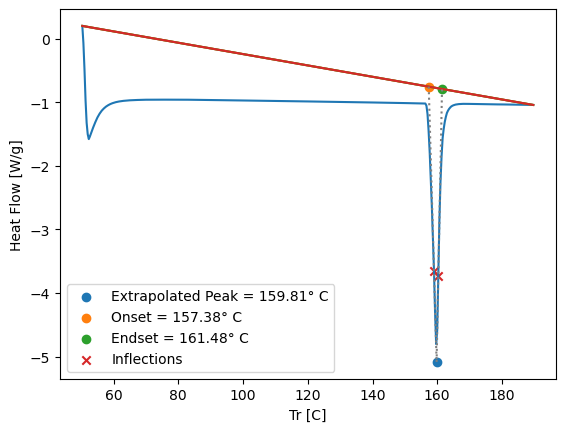

In [13]:
# if you have set your time interval correctly and want to analyze your peak, run the command below
analyze_peak(indium_freezing, xaxis='Tr', verbose=True) # verbose = True will show the plot

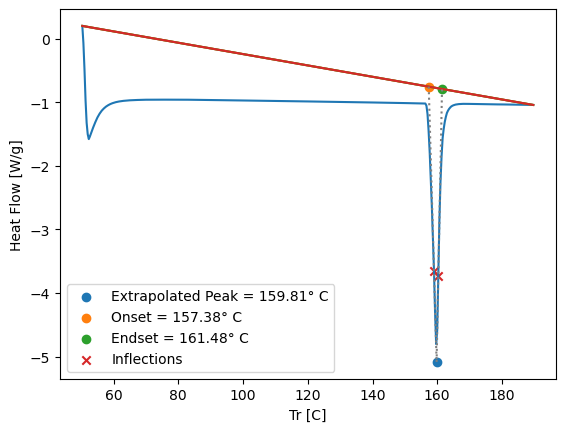

In [14]:
# if you have already run analyze_peak() and only want to make the plot, you can use the command below
plot_analysis(indium_freezing, xaxis='Tr') # note that xaxis here should be the same as the one you used for the analysis

* Plot the peaks corresponding to the two processes, without the baselines, in the same figure.

* Determine the melting and crystallization temperatures from the curves. Determine the melting and crystallization enthalpies. Discuss potential differences between these quantities.

* Report the measured mass of your sample. Calculate the normalized and molar enthalpies of melting and solidification of indium

In [15]:
# write your math here

* Using the following equation, $T_m=\frac{\Delta H_{m}}{\Delta S_{m}}$, calculate the molar entropy from the molar enthalpy of melting. 

## Task 2: Phase Transitions in Paracetatmol (a.k.a. Acetominophene) {-}

In your second experiment you have looked at the phase transitions in one of the most popular drugs. Paracetamol exhibit three non morphisms (forms I-III). You performed two melting runs on the pristine sample and on a melted sample that was cooled at room temperature. 

* Plot the two runs and compare the two different heating curves. 

* Determine the melting temperature and the melting enthalpy for all the transitions in the two runs. 

* Report the mass of your sample. Calculate the normalized (in kJ/g) and molar (in kJ/mol) enthalpies. 

In [16]:
# your math here

* Using the following equation $T_m=\frac{\Delta H_{m}}{\Delta S_{m}},$ compute the molar entropy from the molar enthalpy of melting. 

* Discuss why the two spectra look different. Assuming that the first spectrum is from a crystalline sample (i.e. one of the three polymorphs of paracetamol), determine which form you started with. 

YOUR COMMENTS HERE

## Task 3: Melting Temperature of your Unknown {-}

In your last experiment you have looked at the melting transition of an unknown compound. 

* Plot the DSC curve for your unknown material. 

* Determine the melting transition temperature. 

* Make an educated guess on what your unkown material is.

YOUR GUESS AND COMMENT HERE

## Task 4: Discussion {-}

* Add your results and the correspnding literature values in the following table.

* Discuss on the possible sources of discrepancy between your experiments and the literature. 

YOUR COMMENTS HERE

* In what field is DSC would be useful? Give 2-3 examples.

YOUR COMMENTS HERE

In [17]:
# This cell is used to allow Google Colab to install the tools to convert the notebook to a pdf file
# Un-comment the following lines when you are ready to export the pdf 
#!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
#!pip install pypandoc

In [18]:
# Use this command to convert the finished worksheet into a pdf 
# NOTE : you may want to change the path of the file, if you are working in a different folder of the Google Drive
#!jupyter nbconvert --no-input --to PDF "/content/drive/MyDrive/Colab Notebooks/DSC_Worksheet.ipynb"